## Hierarchical Regression

Hierarchical models enable sharing of features among groups. The parameters of the model are assumed to be sampled from a common distribution that models similarity between groups. The figure below shows three different scenarios that illustrate the benefit of hierarchical modeling. In the figure on the left, we have a single set of parameters $\theta$ that model the entire sequence of observations referred to as a pooled model. Here any variation in data is not modelled explicitly since we are assuming a common set of parameters that give rise to the data. On the other hand, we have an unpooled scenario where we model a different set of parameters for each observation. In the unpooled case, we are assuming that there is no sharing of parameters between groups of observations and that each parameter is independent. The hierarchical model combines the best of both worlds: it assumes that there's a common distribution from which individual parameters are sampled and therefore captures similarities between groups.

<img src="figures/hierarchical_gm.png">

In Bayesian Hierarchical Regression, we can assign priors on model parameters and use MCMC sampling to infer posterior distribution. We use the radon dataset to regress radon gas levels in houses of different counties based on the floor number (in particular if there's a basement or not). Thus our regression model will look like the following:
\begin{equation}
    \alpha_c \sim N(\mu_a, \sigma_{a}^{2})\\
    \beta_c \sim N(\mu_{\beta}, \sigma_{\beta}^{2})\\
    \mathrm{radon}_c = \alpha_c + \beta_c \times \mathrm{floor}_{i,c} + \epsilon_c
\end{equation}

Notice that subscript $c$ indicates a county, thus we are learning an intercept and a slope for each county sampled from a shared Gaussian distribution. Thus, we are assuming a hierarchical model in which our parameters ($\alpha_c$ and $\beta_c$) are sampled from a common distribution. Having specified the model, we can implement it using PyMC3.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pymc3 as pm 

In [5]:
#load data
data = pd.read_csv('./radon.txt')
data.head()

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


In [6]:
county_names = data.county.unique()
county_idx = data['county_code'].values

In [7]:
with pm.Model() as hierarchical_model:
        
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(data.county.unique()))
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    # Expected value
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=data.log_radon)

Having specified the graphical model, we can run inference using the state of the art No-U-Turn Sampler (NUTS) initialized with ADVI.

In [8]:
with hierarchical_model:
    # Use ADVI for initialization
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=hierarchical_model.dict_to_array(sds)**2, is_cov=True)
    hierarchical_trace = pm.sample(5000, step, start=mu)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  This is separate from the ipykernel package so we can avoid doing imports until
Average ELBO = -1,118.2:  49%|████▉     | 48907/100000 [00:15<00:16, 3116.50it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -1,103.6

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
100%|█████████▉| 5494/5500 [00:37<00:00, 143.16it/s]/usr/local/lib/python2.7/dist-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.667219685913, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 5500/5500 [00:37<00:0

Let's examine the trace plots of all our latent variables in the hierarchical regression model:


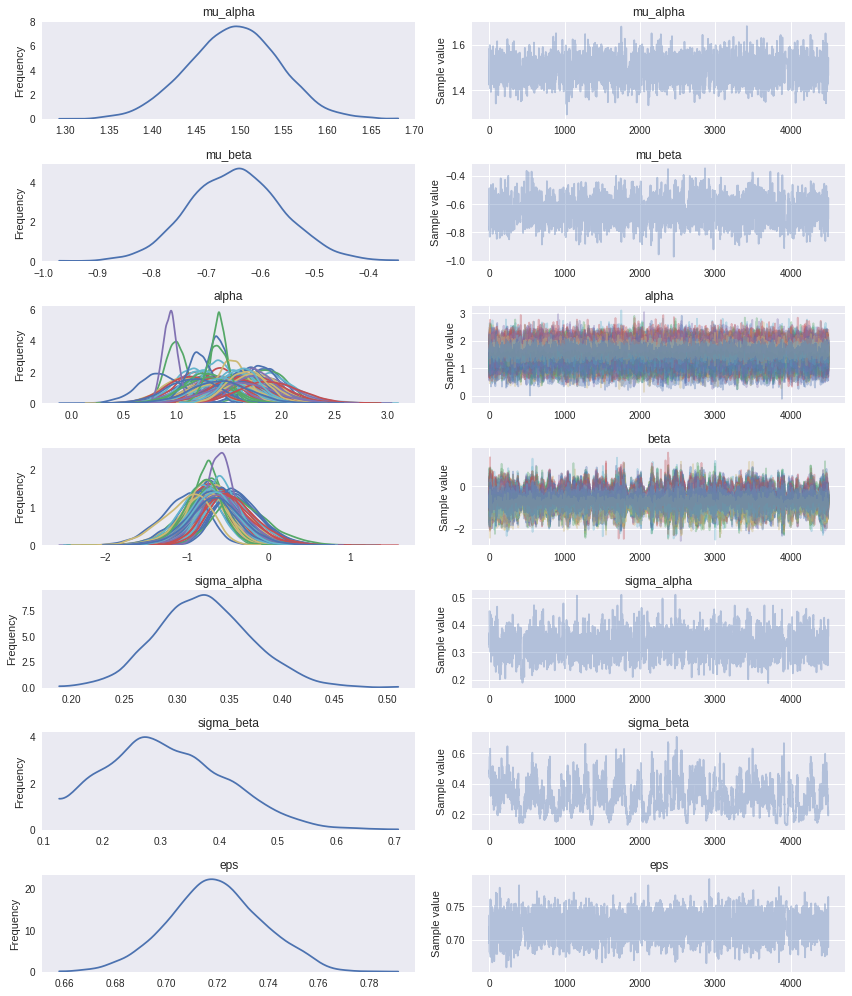

In [9]:
pm.traceplot(hierarchical_trace[500:])
plt.show()

From the traceplots, we can see convergence in our posterior distributions for $\alpha_c$ and $\beta_c$ indicating different intercepts and slopes for different counties. In addition, we also recover the posterior distribution of the shared parameters. $\mu_{\alpha}$ tells us that the group mean of log radon levels is close to $1.5$, while $\mu_{\beta}$ tells us that the slope is negative with a mean of $-0.65$ and thus having no basement decreases radon levels.